In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
%matplotlib inline

In [154]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta

In [155]:
df = pd.read_csv('/content/realdata.csv')

In [156]:
df['timestamp'] = pd.to_datetime(df['createdAt'], format='%Y-%m-%dT%H:%M:%S.%fZ')

In [157]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['date'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second
df['millisecond'] = df['timestamp'].dt.microsecond // 1000

In [158]:
print(df)

       nozzleTemp  bedTemp  xPos  yPos  zPos  fanSpeed  printerSpeed  \
0              98       52    65     7    92        70            32   
1              63       53    77    90    80        53            81   
2              71       77    53    58    93        26            22   
3              57       54    47     3    70        43            46   
4             132      185    82    82    49        55            43   
...           ...      ...   ...   ...   ...       ...           ...   
12923          30       30     3     0    34         0             0   
12924          30       30     3     0    34         0             0   
12925          30       30     3     0    34         0             0   
12926          29       29     3     0    34         0             0   
12927          29       29     3     0    34         0             0   

                      createdAt               timestamp  year  month  date  \
0      2024-04-26T08:57:39.392Z 2024-04-26 08:57:39.392  

In [159]:
print(df.minute.unique(),"\n")
print("Total Number of Minutes", df.minute.nunique(), "\n")


[57 27 28 29 30 53 54 55 56 24 25 26 59  0  1  2 16 17 18 19 20 21 22 23
 36 38 39 41 42 43  8  9 10 11 12 13 15 31 32 33 34 35 37 40 44 45 46 47
 48 49 50 51 52 58  3  4  5  6  7 14] 

Total Number of Minutes 60 



In [160]:
df.drop(['year', 'month', 'date'], axis=1, inplace=True)

In [161]:
df

,nozzleTemp,bedTemp,xPos,yPos,zPos,fanSpeed,printerSpeed,createdAt,timestamp,hour,minute,second,millisecond
0,98,52,65,7,92,70,32,2024-04-26T08:57:39.392Z,2024-04-26 08:57:39.392,8,57,39,392
1,63,53,77,90,80,53,81,2024-04-26T08:57:41.836Z,2024-04-26 08:57:41.836,8,57,41,836
2,71,77,53,58,93,26,22,2024-04-26T08:57:44.010Z,2024-04-26 08:57:44.010,8,57,44,10
3,57,54,47,3,70,43,46,2024-04-26T08:57:46.189Z,2024-04-26 08:57:46.189,8,57,46,189
4,132,185,82,82,49,55,43,2024-04-29T07:27:10.120Z,2024-04-29 07:27:10.120,7,27,10,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12923,30,30,3,0,34,0,0,2024-05-15T05:30:34.857Z,2024-05-15 05:30:34.857,5,30,34,857
12924,30,30,3,0,34,0,0,2024-05-15T05:30:36.190Z,2024-05-15 05:30:36.190,5,30,36,190
12925,30,30,3,0,34,0,0,2024-05-15T05:30:37.520Z,2024-05-15 05:30:37.520,5,30,37,520
12926,29,29,3,0,34,0,0,2024-05-15T07:25:15.106Z,2024-05-15 07:25:15.106,7,25,15,106


In [162]:
df_sorted = df.sort_values(by='minute')

In [163]:
print(df_sorted)

       nozzleTemp  bedTemp  xPos  yPos  zPos  fanSpeed  printerSpeed  \
9039           29       29     0     0     0         0             0   
4371           69       48     0    84     0         0             0   
4372           69       48     0    84     0         0             0   
4373           69       48     0    84     0         0             0   
4374           69       48     0    84     0         0             0   
...           ...      ...   ...   ...   ...       ...           ...   
10521          30       31     9     2    86         0             0   
10520          30       31     9     2    86         0             0   
10519          30       31     9     2    86         0             0   
12596         154       56    72    40    40         0             0   
307            74      173    19    31    98         5            54   

                      createdAt               timestamp  hour  minute  second  \
9039   2024-05-14T04:00:06.667Z 2024-05-14 04:00:06.66

In [164]:
from matplotlib import style

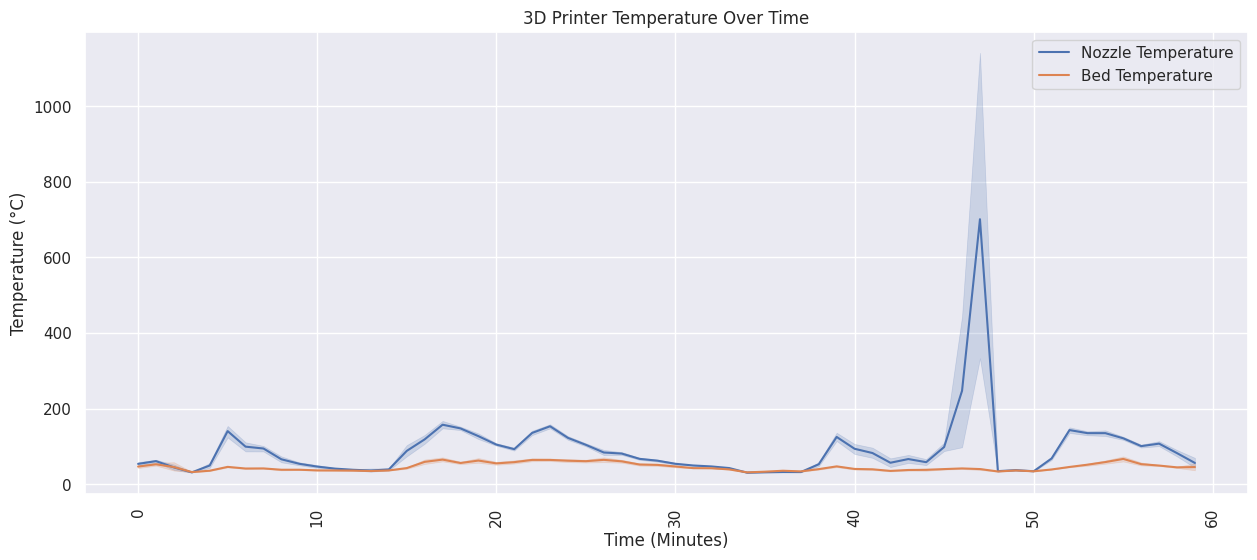

In [165]:
fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0))
style.use('ggplot')
sns.lineplot(x=df_sorted["minute"], y=df_sorted["nozzleTemp"], label='Nozzle Temperature')
sns.lineplot(x=df_sorted["minute"], y=df_sorted["bedTemp"], label='Bed Temperature')
sns.set(rc={'figure.figsize':(15, 6)})
plt.title("3D Printer Temperature Over Time")
plt.xlabel("Time (Minutes)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.legend()
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)
plt.show()


In [166]:
df_sorted.shape

(12928, 13)

In [167]:
test_set = df.tail(3232)

train_set = df.iloc[:,0:1]

train_set = train_set[:-60]

In [168]:
print("Training Set Shape ", train_set.shape)
print("Test Set Shape ", test_set.shape)

Training Set Shape  (12868, 1)
Test Set Shape  (3232, 13)


In [169]:
train_set = train_set.values
sc = MinMaxScaler(feature_range=(0, 1))
train = sc.fit_transform(train_set)

In [171]:
X_Train = []
Y_Train = []

# Range should be fromm 60 Values to END
for i in range(60, train.shape[0]):

    # X_Train 0-59
    X_Train.append(train[i-60:i])

    # Y Would be 60 th Value based on past 60 Values
    Y_Train.append(train[i])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(12808, 60, 1)
(12808, 1)


In [172]:
# Shape should be Number of [Datapoints , Steps , 1 )
# we convert into 3-d Vector or #rd Dimesnsion
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(12808, 60, 1)

In [174]:
from keras.layers import Dropout


In [175]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [176]:
regressor.fit(X_Train, Y_Train, epochs = 50, batch_size = 32)

Epoch 1/50
401/401 [==============================] - 57s 110ms/step - loss: 0.0011
Epoch 2/50
401/401 [==============================] - 45s 113ms/step - loss: 7.3946e-04
Epoch 3/50
401/401 [==============================] - 45s 112ms/step - loss: 7.3198e-04
Epoch 4/50
401/401 [==============================] - 44s 110ms/step - loss: 5.1741e-04
Epoch 5/50
401/401 [==============================] - 47s 117ms/step - loss: 6.0405e-04
Epoch 6/50
401/401 [==============================] - 45s 112ms/step - loss: 4.5882e-04
Epoch 7/50
401/401 [==============================] - 44s 110ms/step - loss: 3.2435e-04
Epoch 8/50
401/401 [==============================] - 48s 120ms/step - loss: 3.7288e-04
Epoch 9/50
401/401 [==============================] - 44s 109ms/step - loss: 3.9748e-04
Epoch 10/50
401/401 [==============================] - 44s 110ms/step - loss: 3.3983e-04
Epoch 11/50
401/401 [==============================] - 45s 112ms/step - loss: 3.6384e-04
Epoch 12/50
401/401 [=============

In [177]:
test_set_scaled = sc.transform(test_set.iloc[:, 0:1])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [178]:
X_test = []
for i in range(60, len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i, 0])

In [179]:
X_test = np.array(X_test)

In [180]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [181]:
predicted = regressor.predict(X_test)

100/100 [==============================] - 9s 37ms/step


In [182]:
predicted = sc.inverse_transform(predicted)

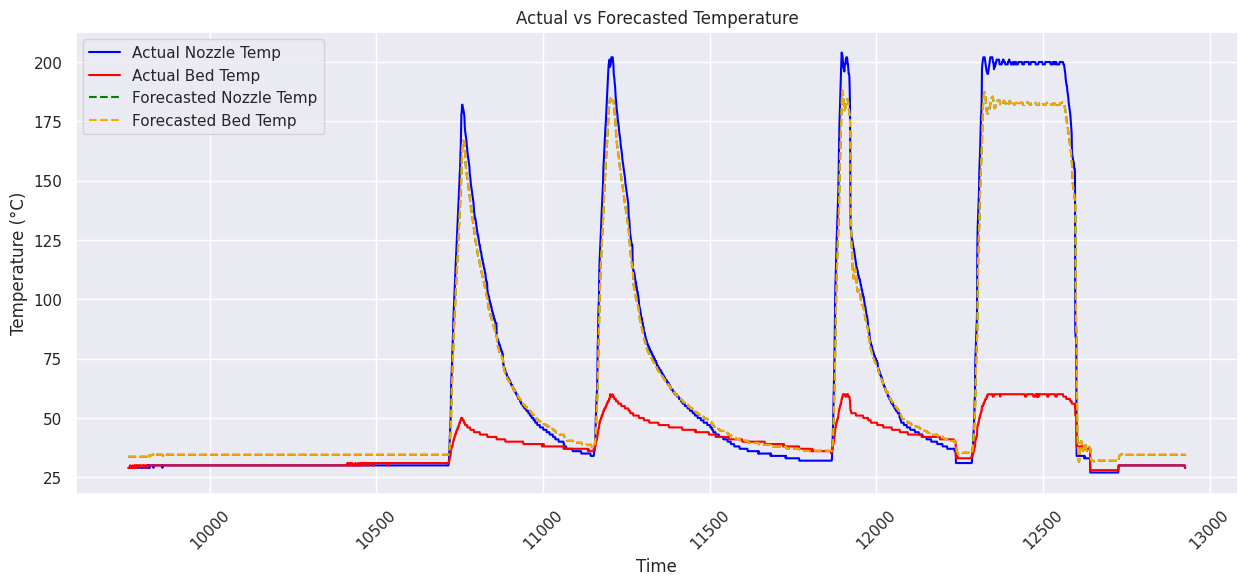

In [183]:
plt.figure(figsize=(15, 6))
plt.plot(test_set.index[60:], test_set['nozzleTemp'][60:], color='blue', label='Actual Nozzle Temp')
plt.plot(test_set.index[60:], test_set['bedTemp'][60:], color='red', label='Actual Bed Temp')
plt.plot(test_set.index[60:], predicted, color='green', linestyle='--', label='Forecasted Nozzle Temp')
plt.plot(test_set.index[60:], predicted, color='orange', linestyle='--', label='Forecasted Bed Temp')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()